# Confidence Intervals

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.graphics.api as smg

sns.set_style('whitegrid')

In [2]:
def ci_experiment(pop_dist=None, confidence=0.9, n=50, bigN=100, figsize=(4,6)):
    '''
    This function simulates bigN samples of size n from the pop_dist distribution
    and shows the confidence intervals calculated from each sample.
    This illustrates what is meant by a confidence interval.
    
    Inputs:
    pop_dist   : A parameterized distribution from scipy.stats. If omitted, will use standard normal
                 This is the distribution of the population, not the sampling distribution
    confidence : The confidence used for the intervals
    n          : The sample size of each simulated sample
    bigN       : The number of simulations to run
    figsize    : Sets the figure size. Defaults to 4x6. This should be a two element numerical tuple
    
    Returns:
    fig        : A figure object containing the plot
    hits       : The number of intervals that included the mean
    '''
    import scipy.stats as stats
    import numpy as np
    if pop_dist == None:
        pop_dist = stats.norm()
    mu = pop_dist.expect()
    fig, ax = plt.subplots(figsize=figsize)
    misses = 0
    for i in range(bigN):
        data = pop_dist.rvs(size=n)
        ci = stats.t(df=n-1, loc=data.mean(), scale=data.std(ddof=1)/np.sqrt(n)).interval(confidence)
        color = 'C0'
        if (mu < ci[0]) or (mu > ci[1]):
            color = 'red'
            misses += 1
        ax.broken_barh([(ci[0], ci[1]-ci[0])], (i-0.4, 0.8), facecolor=color, edgecolor='black')
    ax.axvline(x=mu)
    fig.tight_layout()
    return fig, (bigN - misses)

98 intervals included the actual mean.


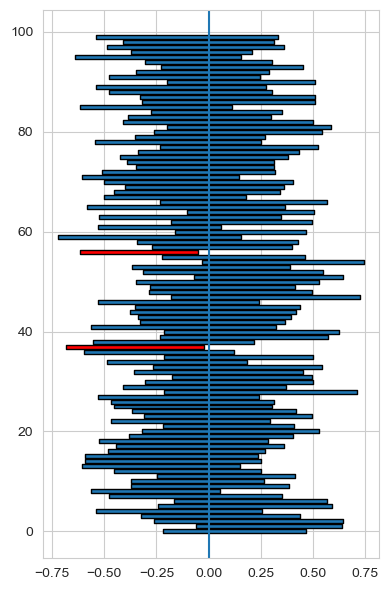

In [3]:
fig, hits = ci_experiment(confidence=0.99)
print(f'{hits} intervals included the actual mean.')
plt.show()

91 intervals included the actual mean.


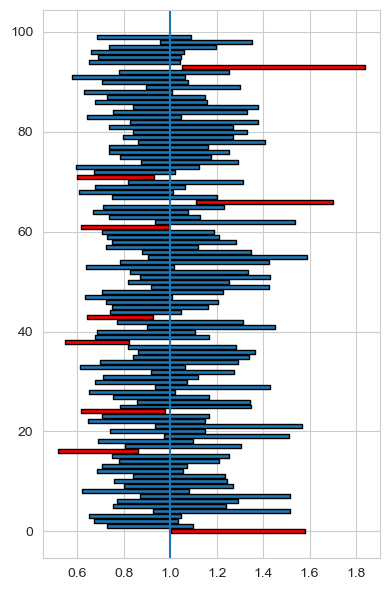

In [4]:
fig, hits = ci_experiment(pop_dist=stats.expon(),confidence=0.9)
print(f'{hits} intervals included the actual mean.')
plt.show()

# Building CI in Python

In [5]:
def plot_ci(interval, dist=None, xlim=[-4,4], figsize=(4,2)):
    '''
    This function plots a distribution and fills the area covered by the confidence given.
    The pdf is filled between the limits of the interval.
    
    Inputs:
    interval : A two-element numerical tuple containing the left and right bounds of the interval
               For one-sided intervals, include math.inf or -math.inf as appropriate
    dist     : A parameterized distribution from scipy.stats. If omitted, will use standard normal
    xlim     : The range of x values you want to plot. If omitted, defaults to [-4,4]
    figsize  : Sets the figure size. Defaults to 4x2. This should be a two element numerical tuple
    
    Returns:
    fig      : A figure object containing the plot
    '''
    import scipy.stats as stats
    import numpy as np
    if dist == None:
        dist = stats.norm()
    pdfx = np.linspace(xlim[0],xlim[1],1000)
    pdf = [dist.pdf(xx) for xx in pdfx]
    ci = (max(xlim[0], interval[0]),min(xlim[1], interval[1]))
    fillx = np.linspace(ci[0], ci[1], 1000)
    filly = [dist.pdf(xx) for xx in fillx]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(pdfx, pdf)
    ax.fill_between(x=fillx, y1=0, y2=filly, color='C0', alpha=0.5, 
                    label=f'Confidence: {dist.cdf(interval[1])-dist.cdf(interval[0]):.3f}'
                   )
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylabel('pdf')
    fig.tight_layout()
    return fig

## Normal CIs

In [6]:
mu = 5
sigma = 2
dist = stats.norm(loc=mu, scale=sigma)

In [7]:
lower = dist.ppf(0.025)
lower

1.080072030919891

In [8]:
upper = dist.isf(0.025)
upper

8.91992796908011

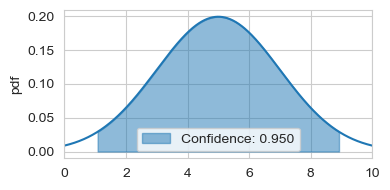

In [9]:
plot_ci(interval=(lower,upper), dist=dist, xlim=[0,10])
plt.show()

In [10]:
dist.interval(confidence=0.95)

(1.080072030919892, 8.919927969080108)

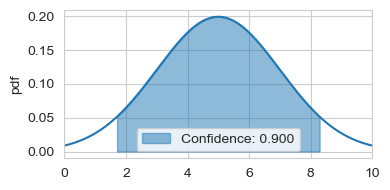

In [11]:
plot_ci(interval=dist.interval(0.9),dist=dist,xlim=[0,10])
plt.show()

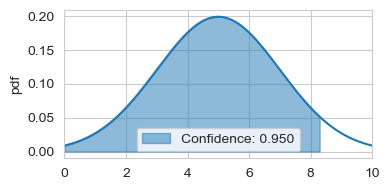

In [12]:
interval = (-math.inf, dist.isf(0.05))
plot_ci(interval=interval,dist=dist,xlim=[0,10])
plt.show()

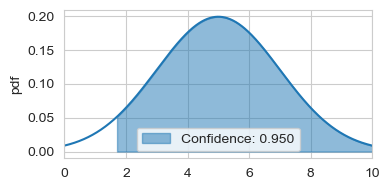

In [13]:
interval = (dist.ppf(.05), math.inf)
plot_ci(interval=interval,dist=dist,xlim=[0,10])
plt.show()

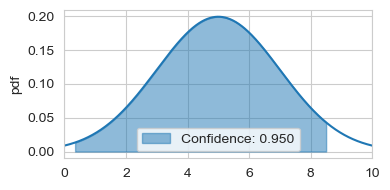

In [14]:
interval = (dist.ppf(.01), dist.isf(.04))
plot_ci(interval=interval,dist=dist,xlim=[0,10])
plt.show()

## t CIs

In [15]:
mu = 5
sigma = 10
n = 25
dist = stats.t(df=n-1, loc=mu, scale=sigma/math.sqrt(n))


In [16]:
dist.interval(0.95)

(0.8722028767439589, 9.127797123256041)

In [17]:
stats.norm(loc=mu,scale=sigma/math.sqrt(n)).interval(0.95)

(1.080072030919892, 8.919927969080108)

## Binomial CIs

In [18]:
p = .9
n = 100
dist = stats.binom(p=p, n=n)
dist.interval(.95)

(84.0, 95.0)

In [19]:
dist.cdf(83)

0.020598810145300107

In [21]:
dist.sf(95)

0.023711082663476803

# Prediction Intervals

In [33]:
pop_dist = stats.norm(loc=5,scale=2)
n = 50
data = pop_dist.rvs(size=n)
data

array([3.43688582, 4.99412183, 2.63015679, 5.32529128, 9.14417061,
       3.85508892, 2.80761371, 5.98183845, 8.23950848, 6.13835456,
       3.44046879, 5.51260822, 4.44179714, 3.29010045, 6.13310722,
       8.1151774 , 8.93248999, 5.75117114, 5.44265257, 3.64097617,
       6.12211339, 7.45293966, 4.27450565, 2.37786365, 7.28365827,
       2.79132116, 5.13260235, 7.22060131, 4.4285998 , 4.48135081,
       2.71083957, 6.13263662, 7.22924208, 4.83148516, 5.57007012,
       4.74072159, 4.81349646, 3.54550909, 2.27561097, 2.04015186,
       7.8933449 , 3.74012023, 6.80675976, 7.18922257, 3.01462684,
       3.61185253, 4.34595731, 4.09263596, 4.13409567, 5.69106122])

In [34]:
ci = stats.t(df=n-1, loc=data.mean(), scale=data.std(ddof=1)*np.sqrt(1/n)).interval(.9)
ci

(4.628276597564701, 5.500866445688685)

In [35]:
pi = stats.t(df=n-1, loc=data.mean(), scale=data.std(ddof=1)*np.sqrt(1+1/n)).interval(.9)
pi

(1.9488025477014403, 8.180340495551945)

In [36]:
def pi_experiment(pop_dist=None, confidence=0.9, n=50, figsize=(3,1)):
    '''
    This function simulates 100 new data points after creating a prediction interval.
    This illustrates what is meant by a prediction interval.
    
    Inputs:
    pop_dist   : A parameterized distribution from scipy.stats. If omitted, will use standard normal
                 This is the distribution of the population, not the sampling distribution
    confidence : The confidence used for the intervals
    n          : The sample size of each simulated sample
    figsize    : Sets the figure size. This should be a two element numerical tuple
    
    Returns:
    fig        : A figure object containing the plot
    hits       : The number of data points captured by the interval
    '''
    import scipy.stats as stats
    import numpy as np
    if pop_dist == None:
        pop_dist = stats.norm()
    data = pop_dist.rvs(size=n)
    pi = stats.t(df=n-1, loc=data.mean(), scale=data.std(ddof=1)*np.sqrt(1+1/n)).interval(confidence)
    fig, ax = plt.subplots(figsize=figsize)
    ax.broken_barh([(pi[0], pi[1]-pi[0])], (0.6,0.8), alpha=0.7)
    new_data = pop_dist.rvs(size=1000)
    ax.scatter(x=new_data, y=np.ones(1000), marker='.')
    misses = sum(new_data < pi[0]) + sum(new_data > pi[1])
    mu = pop_dist.expect()
    ax.set_yticks([])
    fig.tight_layout()
    return fig, (1000 - misses)

The interval included 917/1000 new points.


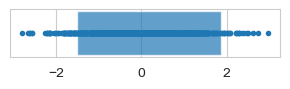

In [43]:
fig, hits = pi_experiment(confidence=0.9)
print(f'The interval included {hits}/1000 new points.')
plt.show()

---
# Progress Check

In [46]:
mu = 110
sigma = 15
n = 30

ci = stats.t(df=n-1, loc=mu, scale=sigma/math.sqrt(n)).interval(.9)
ci

(105.34674899750462, 114.65325100249538)

In [52]:
mu = 231603
sigma = 111360
n = 100

ci = stats.t(df=n-1, loc=mu, scale=sigma*math.sqrt(1/n)).interval(.95)
me = (ci[1] - ci[0])*.5
me


22096.23997200068

In [53]:
pi = stats.t(df=n-1, loc=mu, scale=sigma*math.sqrt(1+1/n)).interval(.95)
me = (pi[1] - pi[0])*.5
me

222064.46341304667